# Homework 1
## Task 1 - pre analysis (0.5 points)
● Take a look (with an eye) at the data set and describe it. Does it look easy or difficult? Is the data properly labeled? What accuracy do you expect as a result and
why?

Answer: First, the data seems to be good processed, since the person is correctly classified in the folders. Having said that, it seems not that easy the recognition of faces, because the expressions, backgrounds, hairstyles and haircolor change a lot. Even more, the quality of the image and the brightness could be an additional impediment for a good classification, noticing that there is even black-and-white images.
As a positive characteristic to remark, is the size of the pictures, that are all square and the same (250x250). It is difficult to guess an acuracy, but I would say 60%, since 6 of 10 pictures of each folder show high similarities in terms of direction of the face, color and luminosity.

## Task 2 - implementation (1.5 point)
● Implement a convolutional neural network.

● The network should consist of no more than four convolutional layers and no more than two fully connected layers.

In [ ]:
# importing the libraries
import pandas as pd
import numpy as np
import os
import time
import copy

# for reading and displaying images
import skimage.io as io
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets,models, transforms
from torchvision import utils
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
import torch.nn.functional as F
from torch.optim import Adam, SGD

### Exploring the data and Pytorch Functionalities
Just to explore how to manage the data in Pytorch, a folder of the train images was uploaded, transformed in tensor and visualized.

---



In [ ]:
# Load CSV
df = pd.read_csv('sample_data/paths.csv')
new = df['DirectoryName,"Name"'].str.split(",", n = 1, expand = True)
df["Directory"]= new[0] 
df["Name"]= new[1]
df.drop(columns =['DirectoryName,"Name"'], inplace = True) 
df['Name'] = df['Name'].str.replace('"','')

df.iloc[1, 1]

'101.jpg'

In [ ]:
## Load Images
def show_landmarks(image):#, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    #plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

# Funtion that read the names of the file and load the data
class FaceLoader(Dataset):
    """Face dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        new = self.landmarks_frame['DirectoryName,"Name"'].str.split(",", n = 1, expand = True) 
        self.landmarks_frame["Directory"]= new[0]
        self.landmarks_frame["Name"]= new[1]
        self.landmarks_frame.drop(columns =['DirectoryName,"Name"'], inplace = True) 
        self.landmarks_frame['Name'] = self.landmarks_frame['Name'].str.replace('"','')
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 1])
        image = io.imread(img_name)
        sample = {'image': image}

        if self.transform:
            sample = self.transform(sample)

        return sample

0 (250, 250, 3)


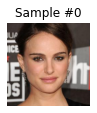

1 (250, 250, 3)


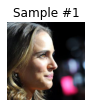

2 (250, 250, 3)


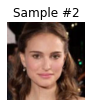

3 (250, 250, 3)


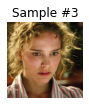

In [ ]:
## Display images

face_dataset = FaceLoader(csv_file='sample_data/paths.csv',
                          root_dir='sample_data/000204/')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape) 

    # To see 4 images and their size

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

In [ ]:
## Class to convert images to Tensors
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image = sample['image']
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image)}

In [ ]:
## Display the images as Tensors
transformation = transforms.Compose([ToTensor()])
transformed_dataset = FaceLoader(csv_file='sample_data/paths.csv',
                          root_dir='sample_data/000204/',
                          transform=transformation)
for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    print(i, sample['image'].size())
    if i == 3:
        break

0 torch.Size([3, 250, 250])
1 torch.Size([3, 250, 250])
2 torch.Size([3, 250, 250])
3 torch.Size([3, 250, 250])


0 torch.Size([4, 3, 250, 250])
1 torch.Size([4, 3, 250, 250])
2 torch.Size([4, 3, 250, 250])
3 torch.Size([4, 3, 250, 250])


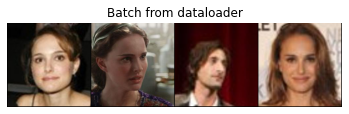

In [ ]:
## Working in Batch
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)

def show_batch(sample_batched):
    """Show image for a batch of samples."""
    images_batch = sample_batched['image']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

### Working with real Data
After being familiarized with the functions to load data and pass images to tensors, the whole dataset is unzipped for further use.

In [ ]:
# Unzipping the whole project
!unzip sample_data/dnn2020-1.zip -d sample_data/

In [ ]:
## Load the train data

# Data train and test in folder with their names
data_transforms = {
    'train': transforms.Compose([transforms.ToTensor()]),
    'test': transforms.Compose([transforms.ToTensor()]),
}
# The root directory of the data
data_dir = 'sample_data/dnn2020-1'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}

# Dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
print("Datasizes: {}".format(dataset_sizes))

# Names of the classes
class_names = image_datasets['train'].classes
print("Number of classes: {}".format(len(class_names)))

# In case GPU is needed
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Datasizes: {'train': 11200, 'test': 2772}
Number of classes: 28


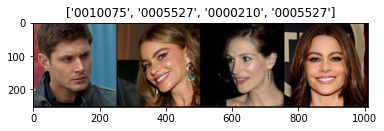

In [ ]:
## Visualizing images

# Function to display and image from a tensor
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

# Display 4 images with their respective classnames as title
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [ ]:
## Create the train function with 10 epochs by default
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
## Creating the Network
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # This network will have 1 convolutional network, one maxpool operation
        # and 2 linear layers to complement. 
        # Images has 3 channels of input and there are 28 classes (output size)
        self.conv1 = torch.nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = torch.nn.Linear(18 * 125 * 125, 64)
        self.fc2 = torch.nn.Linear(64, 28)

    def forward(self, x):
        # Relu activation function
        x = F.relu(self.conv1(x))
        
        # Applying Maxpooling
        x = self.pool(x)
        
        # Reshape data to 18 * 125 * 125 =  281250
        x = x.view(-1, 18 * 125 *125)
        
        # Activation of the first fully connected layer also with Relu
        x = F.relu(self.fc1(x))
        
        #Computes the second fully connected layer 
        x = self.fc2(x)
        return(x)

In [ ]:
# Just a function that helped me calculate the size of the layers
def outputSize(in_size, kernel_size, stride, padding):
  output = int((in_size - kernel_size + 2*(padding)) / stride) + 1
  return(output)
outputSize(250,2,2,0)

125

In [ ]:
# instantiate CNN model
model_ft = CNN()
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# to change the learning rate by runtime
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
# Finally train the model
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 3.3353 Acc: 0.0354


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f1ab4017e80>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f1ab4017e80>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/usr/local/l

test Loss: 3.3324 Acc: 0.0357

Epoch 1/4
----------
train Loss: 3.3333 Acc: 0.0343
test Loss: 3.3323 Acc: 0.0357

Epoch 2/4
----------
train Loss: 3.3333 Acc: 0.0329
test Loss: 3.3323 Acc: 0.0357

Epoch 3/4
----------
train Loss: 3.3333 Acc: 0.0334
test Loss: 3.3322 Acc: 0.0357

Epoch 4/4
----------
train Loss: 3.3332 Acc: 0.0336
test Loss: 3.3323 Acc: 0.0357

Training complete in 85m 41s
Best test Acc: 0.035714


### Results
Visualization of the results and calculation of Confusion Matrix for the 28 classes.

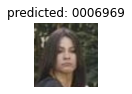

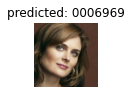

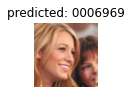

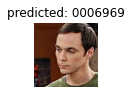

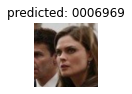

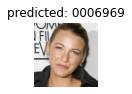

In [ ]:
# To check visualy the results we run visualize_model
visualize_model(model_ft)

In [ ]:
# And finally we evaluate 
nb_classes = 28
confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 99.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 99.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 99.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 99.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 99.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 99.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

# Some observations
For the same class we can see different actors, even for different genders. Actually it seems for the confusion matrix that all the faces were classified as 0006969. Even the males were classified as Elizabeth Banks. 
The results are not good. Not only for the small amount of epochs but also because there were not the best layers. Also the batch_normalization is missing. There is a lot to improve. But, at least the goal of building and training the first convolutional neural network is accomplished, and in the future, with the same time, the results will be probably awesome. 